In [53]:
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sn

In [25]:
transform = transforms.ToTensor()
train_dataset = datasets.CIFAR10(root='../../../../../../notebooks/Data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='../../../../../../notebooks/Data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [50]:
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)

# Define strings for labels.
class_names = ['plane', '  car', ' bird', '  cat', ' deer', '  dog', ' frog', 'horse', ' ship', 'truck']

In [41]:
# Model class.
class ConvolutionalNetwork(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3, stride=1)
        self.fc1 = nn.Linear(in_features=6 * 6 * 16, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=10)
        self.pool1 = nn.MaxPool2d(kernel_size= 2, stride=2)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = self.pool1(X)
        X = F.relu(self.conv2(X))
        X = self.pool1(X)
        X = F.relu(self.fc1(X.view(-1, 6 * 6 * 16)))
        X = F.relu(self.fc2(X))
        return F.log_softmax(self.fc3(X), dim=1)

torch.manual_seed(101)
model = ConvolutionalNetwork()
print(model)

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)


In [42]:
# Train the model.
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

start = time.time()

train_loos = []
test_loss = []
train_correct = []
test_correct = []

epoch = 5

for i in range(epoch):
    i += 1

    trn_crt = 0
    tst_crt = 0
    loss = 0

    for b, (X_train, y_train) in enumerate(train_loader):
        b += 1

        y_pred = model.forward(X_train)
        loss = criterion(y_pred, y_train)

        predicted = torch.max(y_pred, dim=1)[1]
        trn_crt += (predicted == y_train).sum()

        # Back propagate
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if b % 1000 == 0:
            print(f'epoch: {i}, batch: {b} -> loss: {loss:.10f}, accuracy: {trn_crt.item() * 100 / (10 * b):5.2f}%')

    train_loos.append(loss)
    train_correct.append(trn_crt)

    with torch.no_grad():

        for b, (X_test, y_test) in enumerate(test_loader):

            y_pred = model.forward(X_test)
            loss = criterion(y_pred, y_test)

            predicted = torch.max(y_pred, dim=1)[1]
            tst_crt += (predicted == y_test).sum()

        test_loss.append(loss)
        test_correct.append(tst_crt)

duration = time.time() - start
print(f'Duration to execute is {duration / 60:.4f} minutes')

epoch: 1, batch: 1000 -> loss: 1.6749699116, accuracy: 27.12%
epoch: 1, batch: 2000 -> loss: 1.3950109482, accuracy: 32.76%
epoch: 1, batch: 3000 -> loss: 1.7974033356, accuracy: 36.34%
epoch: 1, batch: 4000 -> loss: 1.6223888397, accuracy: 38.90%
epoch: 1, batch: 5000 -> loss: 2.2970585823, accuracy: 40.82%
epoch: 2, batch: 1000 -> loss: 1.5230157375, accuracy: 50.16%
epoch: 2, batch: 2000 -> loss: 1.5579280853, accuracy: 51.01%
epoch: 2, batch: 3000 -> loss: 0.8230210543, accuracy: 51.12%
epoch: 2, batch: 4000 -> loss: 1.1655601263, accuracy: 51.58%
epoch: 2, batch: 5000 -> loss: 1.5814387798, accuracy: 52.10%
epoch: 3, batch: 1000 -> loss: 0.7350902557, accuracy: 55.85%
epoch: 3, batch: 2000 -> loss: 1.3391796350, accuracy: 56.27%
epoch: 3, batch: 3000 -> loss: 1.6166124344, accuracy: 56.75%
epoch: 3, batch: 4000 -> loss: 1.1405507326, accuracy: 56.68%
epoch: 3, batch: 5000 -> loss: 0.7074754834, accuracy: 56.89%
epoch: 4, batch: 1000 -> loss: 1.9470241070, accuracy: 58.25%
epoch: 4

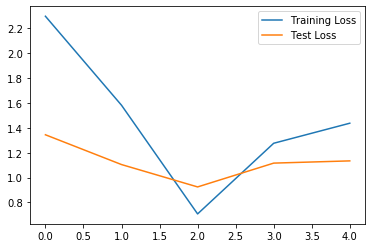

In [43]:
plt.plot(train_loos, label="Training Loss")
plt.plot(test_loss, label='Test Loss')
plt.legend()

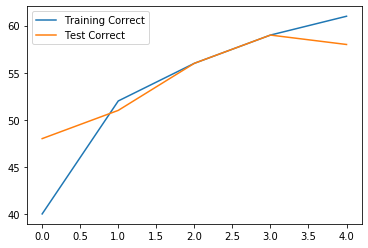

In [47]:
plt.plot([t/500 for t in  train_correct], label="Training Correct")
plt.plot([t/100 for t in test_correct], label="Test Correct")
plt.legend()

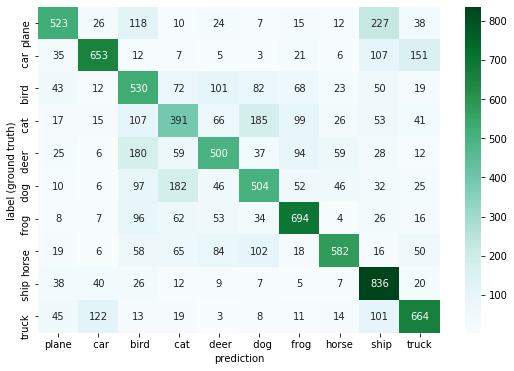

In [57]:
# Create a loader for the entire the test set
test_load_all = DataLoader(test_dataset, batch_size=10000, shuffle=False)

with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = model(X_test)
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()

arr = confusion_matrix(y_test.view(-1), predicted.view(-1))
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize = (9,6))
sn.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show();